## Collection_DS_takehome_challenges: Employee Retention

### Kanja Saha
### 11/15/2018

### Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience. As said above, the goal is to predict employee retention and understand its main drivers. 

Speciﬁcally, you should: 
- Assume, for each company, that the headcount starts from zero on 2011/01/23.
- Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. 
- You should create a table with 3 columns: day, employee_headcount, company_id. 
- What are the main factors that drive employee churn? Do they make sense? Explain your ﬁndings. 
- If you could add to this data set just one variable that could help explain employee churn, what would that be?

### 1. Import Libraries & Data Load 

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from IPython.display import display,Markdown
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

def printbold(string,df):
    display(Markdown(string),df)

In [2]:
df=pd.read_csv("employee_retention_data.csv")

display(df.head())
df.info()


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [3]:
def rstr(df): return df.shape, df.apply(lambda x: [x.unique()])

print(rstr(df))

((24702, 7), employee_id    [[13021.0, 825355.0, 927315.0, 662910.0, 25697...
company_id             [[7, 4, 2, 9, 1, 6, 10, 5, 3, 8, 11, 12]]
dept           [[customer_service, marketing, data_science, e...
seniority      [[28, 20, 14, 23, 21, 4, 7, 13, 17, 1, 10, 6, ...
salary         [[89000.0, 183000.0, 101000.0, 115000.0, 27600...
join_date      [[2014-03-24, 2013-04-29, 2014-10-13, 2012-05-...
quit_date      [[2015-10-30, 2014-04-04, nan, 2013-06-07, 201...
dtype: object)


In [4]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


You should create a table with 3 columns: day, employee_headcount, company_id. 

In [5]:
unique_dates = pd.DataFrame(pd.date_range(start='2011/01/24', end='2015/12/13'))
# create list of unique dates for the table 
unique_companies = pd.DataFrame(df.company_id.unique())
#ceate list of unique companies 
unique_dates['key'] = 1
unique_companies['key'] = 1
date_company =pd.merge(unique_dates, unique_companies, on=['key'])
date_company = date_company.drop('key', axis=1)
date_company.columns = ["date", "company_id"] 
date_company.head()


,date,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


As stated in the description, spain indeed have a higher conversion with the translated version.

In [23]:
#now I get for each day/company, how many people quit/got hired on that day
df_join_count=df.groupby(['join_date','company_id']).employee_id.nunique().to_frame('hire_count').reset_index()
#df_join_count.columns=df_join_count.columns.droplevel()
df_quit_count=df.groupby(['quit_date','company_id']).employee_id.nunique().to_frame('quit_count').reset_index()
#df['size'] = df.groupby(['join_date']).employee_id.transform('nunique')
join_quit_count_by_date=pd.merge(date_company, df_join_count, left_on=['date','company_id'], right_on=['join_date','company_id'], how="left").merge(df_quit_count, how="left",left_on=['date','company_id'], right_on=['quit_date','company_id'])#.merge(df, how="left",left_on=['date','company_id'], right_on=['quit_date','company_id'])
join_quit_count_by_date.fillna(0, inplace=True)
join_quit_count_by_date.head()


,date,company_id,join_date,hire_count,quit_date,quit_count
0,2011-01-24,7,0,0.0,0,0.0
1,2011-01-24,4,0,0.0,0,0.0
2,2011-01-24,2,0,0.0,0,0.0
3,2011-01-24,9,0,0.0,0,0.0
4,2011-01-24,1,0,0.0,0,0.0


In [77]:
join_quit_count_by_date['join_cum_sum'] = join_quit_count_by_date["hire_count"].cumsum()
join_quit_count_by_date['quit_cum_sum'] = join_quit_count_by_date["quit_count"].cumsum()
#join_quit_count_by_date[(join_quit_count_by_date.join_cum_sum !=0)].head()
df['employment_length'] =  (pd.to_datetime(df['quit_date']) - pd.to_datetime(df['join_date'])).astype('timedelta64[D]')#.fillna(0,inplace=True)
df['week_of_year'] =  pd.to_datetime(df['join_date']).dt.week

.Now let’s try to understand employee retention. Here the main challenge is about feature engineering.
That is, extract variables from the quitting_date column.

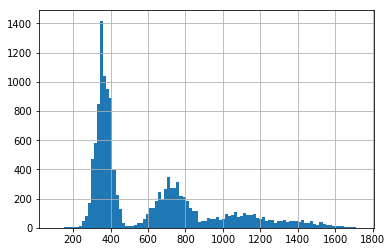

In [76]:
#df['employment_length']=df['employment_length'].astype('timedelta64[D]')#.astype('float')
9df['employment_length'].hist(bins=100)

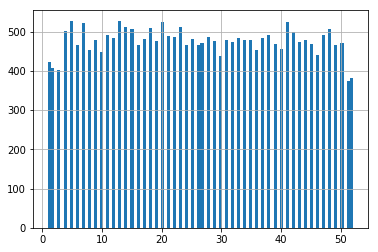

In [78]:
df['week_of_year'].hist(bins=100)

In [90]:
df_130_plus=df[df.employment_length >=130]
df_130_plus['early_quitter']=np.where(df_130_plus['employment_length']>=365, 0, 1)

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
df_130_plus["decile_rank"]=pd.qcut(df_130_plus["employment_length"],30,labels=False)
df_130_plus.head()

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_year,early_quitter,decile_rank
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,13,0,16
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,18,1,4
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,20,0,11
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,42,0,25
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578.0,5,0,16


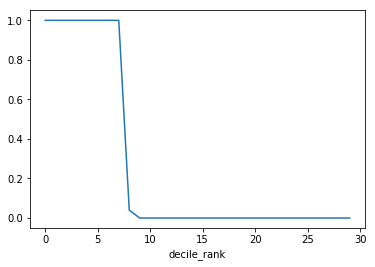

In [131]:
decile_proportion=df_130_plus.groupby("decile_rank").apply(lambda x: x[x['early_quitter'] == 1].early_quitter.sum()/x.early_quitter.size)
#/x['early_quitter'].size
decile_proportion.plot()

In [158]:
from sklearn.tree import DecisionTreeClassifier,_tree
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from graphviz import Source
import graphviz
from sklearn import tree
import pydotplus
import collections
#make dummy vars
data_dummy = pd.get_dummies(df_130_plus)
#model features, test is the label and conversion is not needed here
train_cols = data_dummy.drop(['early_quitter'], axis=1)
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['early_quitter'])
export_graphviz(tree, out_file="1tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("1tree_test.dot") as f:
    dot_graph = f.read()
s = Source.from_file("1tree_test.dot")
s.view()


#graphviz.Source(dot_graph).view()

'1tree_test.dot.pdf'

In [ ]:
#make dummy vars
data_dummy = pandas.get_dummies(data)
#model features, test is the label and conversion is not needed here
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['test'])
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_test.dot")
s.view()

In [144]:
from sklearn.tree import DecisionTreeClassifier,_tree
import numpy as np


data_test_clean=df_130_plus.dropna(axis = 0).reset_index()
dt = data_test_clean
samples_1 = len(dt)
#take one percent randomsampling of the data
dt_random_sample_1_percent=dt.sample(n=samples_1)
test_group = dt_random_sample_1_percent['early_quitter']
features = dt_random_sample_1_percent.drop('early_quitter', axis = 1)
features_d=pd.get_dummies(features)

dtree= DecisionTreeClassifier()
dtree.fit(features_d,test_group)
#clf.tree_.apply(np.asfortranarray(features_d.astype(_tree.DTYPE)))



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

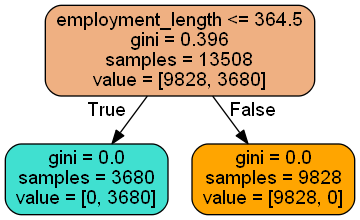

In [145]:
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
import pydotplus
import collections
data_feature_names=features_d.columns
dot_data = export_graphviz(dtree,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

Image(graph.create_png())

Not very surprising! Salary is what matters the most. After all, it probably has within it information about
the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much
all the information available.
It is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 62500
and 224500, the employee has higher probability of being an early quitter, otherwise she doesn’t. That
means that people who make a lot of money and very little are not likely to quit (“little money” by
Silicon Valley standards).
By plotting the proportion of early quitter by salary percentile, this becomes quite clear:

Conclusions
1. Given how important is salary, I would definitely love to have as a variable the salary the employee
who quit was offered in the next job. Otherwise, things like: promotions or raises received during
the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year.
Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before
quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is
well known to be the best time to change job: companies are hiring more and you often want to stay
until end of Dec to get the calendar year bonus.
3. Employees with low and high salaries are less likely to quit. Probably because employees with high
salaries are happy there and employees with low salaries are not that marketable, so they have a
hard time finding a new job.

In [ ]:
# ttest By Country
#stats.ttest_ind(data_test[data_test.test == 1].conversion, data_test[data_test.test == 0].conversion)
from collections import defaultdict
# get a list of all columns in the dataframe without the Group column
country_list = data_test_clean.country.unique()
# create an empty dictionary
t_test_results = {}
mean ={}
# loop over column_list and execute code explained above
for country in country_list:
    group_test = data_test_clean.where((data_test_clean.test== 1)  & (data_test_clean.country==country)).dropna().conversion
    group_control = data_test_clean.where((data_test_clean.test== 0)  & (data_test_clean.country==country)).dropna().conversion
    #display(group_control.head())
    # add the output to the dictionary 
    t_test_results[country]=(group_test.mean())
    t_test_results[country] = stats.ttest_ind(group_test,group_control)
    mean[country]=group_test.mean(),group_control.mean()
    #group_test.mean(),group_control.mean()
    #t_test_results
    
    
results_df1 = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df2 = pd.DataFrame.from_dict(mean,orient='Index')
results_df2.columns = ['test mean','test control']
result = results_df1.join(results_df2,  how='inner', lsuffix='', rsuffix='', sort=False)
result

### ttest By Country

In [ ]:
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
import pydotplus
import collections
data_feature_names=features_d.columns
dot_data = export_graphviz(dtree,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

Image(graph.create_png())